# Assignment 3 Solutions
## Problem 1)

In [343]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

class CelebMatching():
    """ Celebrity Matching. """
    def __init__(self, face_img, data_path, img_size, cell_size, 
                 window_size):
        """
        Initialize parameters.
        """
        self.face_img = face_img
        self.data_path = data_path
        self.img_size = img_size
        self.cell_size = cell_size
        self.window_size = window_size
        
    def __local_binary_pattern(self, cell):
        """
        Find local binary pattern for given cell.
        
        @param cell: cell to find LBP for
        
        @return lbp_feats: local binary pattern for respective cell
        """
        # array to store lbp
        lbp_feats = np.zeros_like(cell)
        cell = np.pad(cell, (1,1), 'constant')
        for i in range(1, cell.shape[0]-1):
            for j in range(1, cell.shape[1]-1):
                # select 3x3 region centered at cell[i, j]
                region = np.int_(cell[i-1:i+2, j-1:j+2])
                # threshold values with center of region
                region = cell[i, j] - region
                thres = np.zeros((3, 3), dtype=np.uint8)
                thres[np.where(region >= 0)] = 1
                # compute decimal value
                thres = thres.astype(str)
                b = thres[0,0]+thres[0,1]+thres[0,2]+thres[1,0]+\
                    thres[1,2]+thres[2,0]+thres[2,1]+thres[2,2]
                dec = int(b, 2)
                lbp_feats[i-1, j-1] = dec
        return lbp_feats
                       
    def __compute_lbp(self, img):
        """
        Computes Local Binary Pattern.
        
        @param img: image to compute LBP for
        
        @return feats: list of LBP features
        """
        # store global feature fector
        feats = np.zeros((self.cell_size[0]*self.cell_size[1], 256))
        # divide image into cells
        for i in range(self.cell_size[0]):
            for j in range(self.cell_size[1]):
                # set cell to image portion
                cell = img[i*self.window_size[0]:(i+1)*self.window_size[0],
                        j*self.window_size[1]:(j+1)*self.window_size[1]]
                lbp = self.__local_binary_pattern(cell)
                # compute histogram
                hist, _ = np.histogram(lbp.ravel(), bins=256)
                # normalize histogram
                hist = hist / sum(hist)
                # concatenate into global feature
                feats[i*self.cell_size[1] + j] = hist
        return feats
    
    def __score(self, my_feats, all_feats):
        """
        Find closest matched image.
        
        @param my_feats: numpy array of LBP features for my facial image
        @param all_feats: numpy array of LBP features for all images 
                            in dataset
        
        @return min_idx: index corresponding to closest image in dataset
        """
        ssd = all_feats - my_feats
        ssd = np.reshape(ssd, (all_feats.shape[0], -1))
        ssd = np.sum(ssd, axis=1)
        min_idx = np.argmin(ssd)
        return min_idx
    
    def run(self):
        """
        Run Celebrity Matching algorithm.
        """
        print('Running algorithm...')
        # find my face features
        my_feats = self.__compute_lbp(self.face_img)
        # read image list
        img_list = os.listdir(self.data_path)
        # store lbp features for all images        
        all_feats = np.zeros((len(img_list), my_feats.shape[0],
                              my_feats.shape[1]))
        for i, img_path in enumerate(img_list):
            if i % 1000 == 0:
                print('Image', i+1, '/ 20000')
            img = cv2.imread(self.data_path + img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, self.img_size)
            # store img feature vector
            feats = self.__compute_lbp(img)
            all_feats[i] = feats
        
        best_idx = self.__score(my_feats, all_feats)
        best_img = img_list[best_idx]
        return cv2.imread(self.data_path + best_img)

In [344]:
# Helper Functions #
def crop_face(img_path, img_size):
    """
    Crop face from input image.
    
    @param img_path: path of input image
    @param img_size: reshape face image to this size
    
    @return face: matrix containing cropped face image
    @return face_img: matrix containing grayscale/resized face image
    """
    img = cv2.imread(img_path)
    face = img[1400:2300, 450:1100]
    face_img = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    face_img = cv2.resize(face_img, img_size)
    return face, face_img

def main():
    """ Main function. """
    img_path = 'Me.jpg'
    data_path = 'img_align_celeb/'
    img_size = (128,128)
    face, face_img = crop_face(img_path, img_size)
    # create celebrity matching object
    cmatch = CelebMatching(face_img=face_img, data_path=data_path,
                           img_size=(128,128), cell_size=(7,7), 
                           window_size=(18,21))
    best_match = cmatch.run()
    
    # display best match
    plt.figure()
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.title('My Face'), plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(best_match, cv2.COLOR_BGR2RGB))
    plt.title('Celebrity Best Match'), plt.xticks([]), plt.yticks([])
    plt.show()

    
if __name__ == '__main__':
    main()

Running algorithm...
Image 1 / 20000


KeyboardInterrupt: 

## Problem 2)

In [312]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class KMeans():
    """ K Means Algorithm. """
    def __init__(self, img, K):
        """
        Initialize parameters.
        
        @param img: input image 
        @param K: number of clusters
        """
        self.img = img
        self.K = K
    
    def __feature_vector(self):
        """
        Converts input image to intensity feature vector.
        
        @return data: intensity feature vector of input image
        """
        data = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        data = np.reshape(data, self.img.shape[0]*self.img.shape[1])
        return data
        
    def __find_clusters(self, data, mu):
        """
        Find clusters associated with each mean.
        
        @param data: input feature vector
        @param mu: array of means
        
        @return labels: label for each feature
        """
        temp = np.array([(data-c)**2 for c in mu]).T
        labels = np.argmin(temp, axis=1)
        return labels
    
    def __find_means(self, data, labels):
        """
        Find means associated with each cluster
        
        @param data: input feature vector
        @param labels: label for each feature
        
        @return mu: updated cluster means
        """
        mu = []
        for i in range(self.K):
            c = data[labels == i]
            mu.append(np.mean(c))
        return mu
    
    def set_k(self, K):
        """
        Set number of clusters.
        
        @param K: number of clusters
        """
        self.K = K
        
    def run(self, num_iterations):
        """
        Run KMeans algorithm.
        
        @param num_iterations: number of interations to run Kmeans
        
        @return labels: label associated with each feature
        @return mu: mean for each cluster
        """
        # convert image to feature vector and store in self.__feats
        data = self.__feature_vector()
        # randomly initialize K-clusters
        mu = np.random.randint(0, 256, self.K)
        # for number of iterations
        for i in range(num_iterations):
            # find cluster labels
            labels = self.__find_clusters(data, mu)
            # update means
            mu = self.__find_means(data, labels)
        return labels, mu
            

In [340]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

class GMM():
    """ Gaussian Mixture Model. """
    def __init__(self, img, K):
        """
        Initialize parameters.
        
        @param img: input image 
        @param K: number of clusters
                    @pre K = 2 or 4
        """
        self.img = img
        self.K = K
    
    def __feature_vector(self):
        """
        Converts input image to intensity feature vector.
        
        @return data: intensity feature vector of input image
        """
        data = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        data = np.reshape(data, self.img.shape[0]*self.img.shape[1])
        return data
    
    def __initialize_clusters(self, data):
        """
        Initialize GMM clusters.
        
        @param data: intensity feature vector of input image
        
        @return labels: label associated with each pixel
        """
        # indices to splitting data initially
        prev_idx = 0
        labels = np.zeros_like(data)
        for k in range(self.K):
            idx = (1/self.K) * 255 * (k+1)
            labels[np.where((data >= prev_idx) & (data < idx))] = k
            prev_idx = idx
        return labels
    
    def __gaussian(self, data, m, v):
        """
        Gaussian probability for each cluster.
        
        @param data: intensity feature vector of input image
        @param m: mean scalar
        @param v: variance scalar
        
        @return labels: label associated with each pixel
        """
        c = 1 / (math.sqrt(2*math.pi) * math.sqrt(v))
        probs = c * np.exp(-((data - m)**2) / (2*v))
        return probs
        
    def __expectation(self, data, mu, var, alpha):
        """
        Perform expectation step in EM algorithm
        
        @param data: intensity feature vector of input image
        @param mu: list of gaussian means
        @param var: list of gaussian variance
        @param alpha: list of gaussian weighing factors
        
        @return labels: label associated to each pixel
        """
        probs = np.array([self.__gaussian(data, mu[k], var[k]) for k in range(self.K)]).T
        probs *= alpha
        for row in probs:
            row /= sum(row)
        labels = np.argmax(probs, axis=1)
        return labels
    
    def __maximization(self, data, labels):
        """
        Perform maximization step in EM algorithm.
        
        @param data: intensity feature vector of input image
        @param labels: label associated with each pixel
        
        @return mu: list of updated gaussian means
        @return var: list of updated gaussian variance
        @return alpha: list of updated gaussian weighing factors
        """
        # list to hold new means, variances, and alphas
        mu = []
        var = []
        alpha = []
        for k in range(self.K):
            X = data[np.where(labels==k)[0]]
            mu.append(np.mean(X))
            var.append(np.var(X))
            alpha.append(len(X) / len(data))
        return mu, var, alpha
    
    def set_k(self, K):
        """
        Set number of clusters.
        
        @param K: number of clusters
        """
        self.K = K
    
    def run(self, num_iterations):
        """
        Run Gaussian Mixture Model.
        
        @param num_iterations: number of iterations to run algorithm
        
        @return labels: label associated with each pixel
        @return mu: mean for each cluster
        """
        # convert image to feature vector
        data = self.__feature_vector()
        # initialize clusters
        labels = self.__initialize_clusters(data)
        # run EM algorithm
        for i in range(num_iterations):
            mu, var, alpha = self.__maximization(data, labels)
            labels = self.__expectation(data, mu, var, alpha)
        return labels, mu

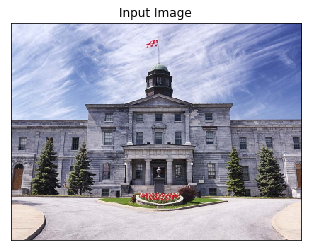

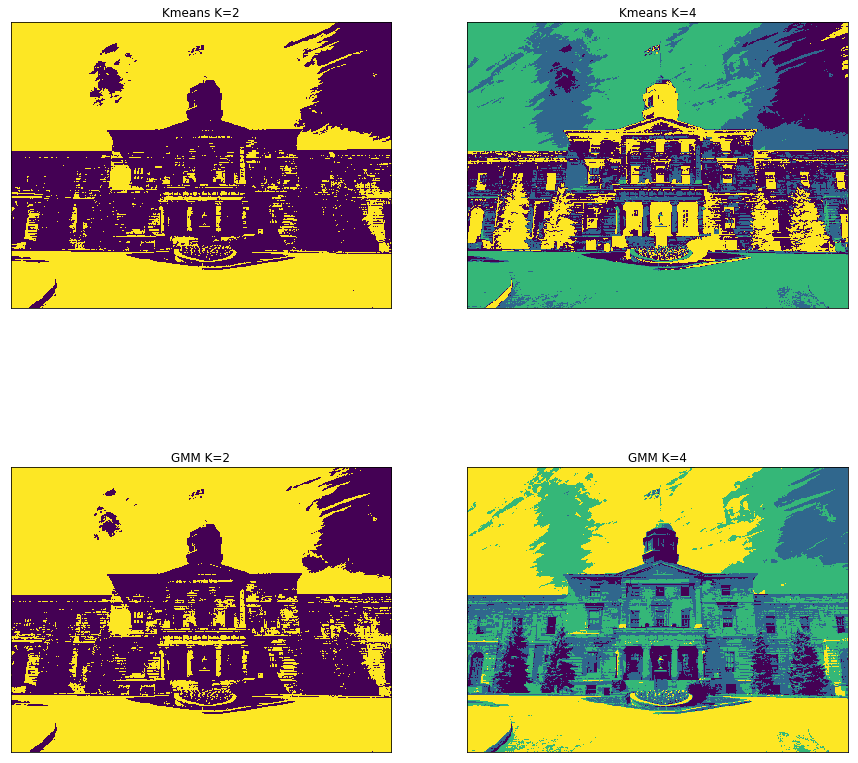

In [342]:
def main():
    """ Main Function. """
    img = cv2.imread('mcgill.jpg')
    img = cv2.resize(img, None, fx=0.5, fy=0.5)
    height, width = img.shape[:2]
    
    # create KMeans object
    kmeans = KMeans(img, K=2)
    labels1, _ = kmeans.run(num_iterations=10)
    kmeans.set_k(K=4)
    labels2, _ = kmeans.run(num_iterations=10)
    
    # create GMM object
    gmm = GMM(img, K=2)
    labels3, _ = gmm.run(5)
    gmm.set_k(K=4)
    labels4, _ = gmm.run(5)
    
    # reshape labels into images
    img_label1 = np.reshape(labels1, (height, width))
    img_label2 = np.reshape(labels2, (height, width))
    img_label3 = np.reshape(labels3, (height, width))
    img_label4 = np.reshape(labels4, (height, width))
    
    # display images
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    
    plt.figure(figsize=(15,15))
    plt.subplot(221), plt.imshow(img_label1)
    plt.title('Kmeans K=2'), plt.xticks([]), plt.yticks([])
    plt.subplot(222), plt.imshow(img_label2)
    plt.title('Kmeans K=4'), plt.xticks([]), plt.yticks([])
    plt.subplot(223), plt.imshow(img_label3)
    plt.title('GMM K=2'), plt.xticks([]), plt.yticks([])
    plt.subplot(224), plt.imshow(img_label4)
    plt.title('GMM K=4'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    
if __name__ == '__main__':
    main()